# Log Dataset as Weights and Biases Artifact

In [1]:
import wandb
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from pythonScript.modules.data_preprocessing import load_images_from_folder, ImageType, Label, ECGLabel, ecg_label_map

In [3]:
TEST_PATH = os.path.join(".", "ecg_image_data", "test")
TRAIN_PATH = os.path.join(".", "ecg_image_data", "train")

In [4]:
# PATH_WITH_SIGN = os.path.join(".", "data", "y")
# PATH_WITHOUT_SIGN = os.path.join(".", "data", "n")
# IMAGE_SIZE = (250, 250)
IMAGE_SIZE = (288, 432)

In [5]:
# Load Test Images
test_images = None
test_labels = None
for folder in os.listdir(TEST_PATH):
    path = os.path.join(TEST_PATH, folder)
    if not os.path.isdir(path):
        print(path)
        continue

    images, label = load_images_from_folder(path, ecg_label_map[folder], IMAGE_SIZE, ImageType.ORIGINAL)
    print(images.shape)
    
    if test_images is None:
        test_images = images.copy()
        test_labels = label.copy()
    else:
        test_images = np.concatenate((test_images, images), axis=0)
        test_labels = np.concatenate((test_labels, label), axis=0)

test_images.shape, test_labels.shape

./ecg_image_data/test/.DS_Store
(18926, 288, 432, 3)
(556, 288, 432, 3)
(161, 288, 432, 3)
(2101, 288, 432, 3)
(1447, 288, 432, 3)
(1608, 288, 432, 3)


((24799, 288, 432, 3), (24799,))

In [6]:
# Load Train Images
train_images = None
train_labels = None
for folder in os.listdir(TRAIN_PATH):
    path = os.path.join(TRAIN_PATH, folder)
    if not os.path.isdir(path):
        print(path)
        continue

    images, label = load_images_from_folder(path, ecg_label_map[folder], IMAGE_SIZE, ImageType.ORIGINAL)
    print(images.shape)
    
    if train_images is None:
        train_images = images.copy()
        train_labels = label.copy()
    else:
        train_images = np.concatenate((train_images, images), axis=0)
        train_labels = np.concatenate((train_labels, label), axis=0)

train_images.shape, train_labels.shape

./ecg_image_data/train/.DS_Store
(75709, 288, 432, 3)
(2223, 288, 432, 3)
(642, 288, 432, 3)
(8405, 288, 432, 3)
(5789, 288, 432, 3)
(6431, 288, 432, 3)


((99199, 288, 432, 3), (99199,))

In [7]:
# Get Validation set from train set
train_images, validation_images, train_labels, validation_labels = (
    train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
)

(<matplotlib.image.AxesImage at 0x13f1d29c0>, np.int64(2))

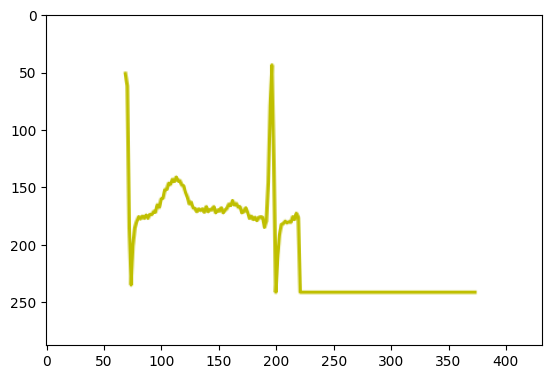

In [8]:
plt.imshow(train_images[0]), train_labels[0]

(<matplotlib.image.AxesImage at 0x14bd03710>, np.int64(4))

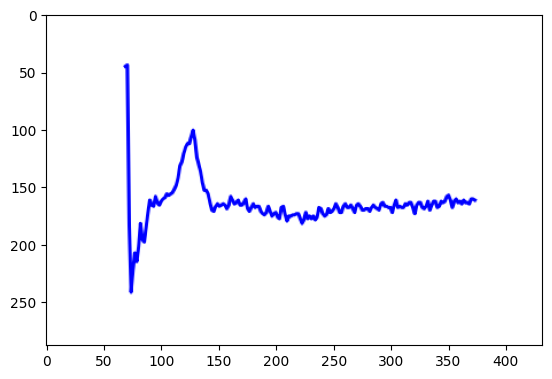

In [9]:
plt.imshow(validation_images[0]), validation_labels[0]

(<matplotlib.image.AxesImage at 0x14bbb7770>, np.int64(2))

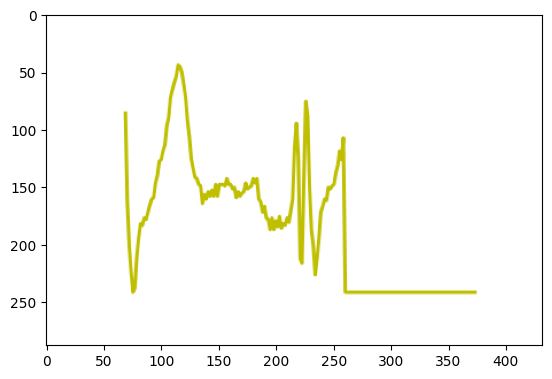

In [10]:
plt.imshow(test_images[0]), test_labels[0]

In [11]:
np.unique(test_labels)

array([0, 1, 2, 3, 4, 5])

## Normal

In [12]:
with wandb.init(project="VisionTransformer", job_type="load-data", entity="silvan-wiedmer-fhgr") as run:
    raw_data = wandb.Artifact(
        "ecg-image-data-no-preprocessing", type="dataset", metadata={"source": "ecg-image-data", "size": len(np.concatenate((train_images, validation_images, test_images), axis=0))}
        )

    # Training
    with raw_data.new_file("training-no-preprocessing.npy", mode="wb") as fh:
        np.savez_compressed(fh, images=train_images, labels=train_labels)

    # Validation
    with raw_data.new_file("validation-no-preprocessing.npy", mode="wb") as fh:
        np.savez_compressed(fh, images=validation_images, labels=validation_labels)

    # Test
    with raw_data.new_file("test-no-preprocessing.npy", mode="wb") as fh:
        np.savez_compressed(fh, images=test_images, labels=test_labels)

    run.log_artifact(raw_data)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: silvan-wiedmer (silvan-wiedmer-fhgr). Use `wandb login --relogin` to force relogin


## Preprocessed

In [13]:
images_with_sign_canny, labels_with_sign_canny = load_images_from_folder(
    PATH_WITH_SIGN, Label.WITH_SIGN, IMAGE_SIZE, img_type=ImageType.CANNY
)
images_without_sign_canny, labels_without_sign_canny = load_images_from_folder(
    PATH_WITHOUT_SIGN, Label.WITHOUT_SIGN, IMAGE_SIZE, img_type=ImageType.CANNY
)

NameError: name 'PATH_WITH_SIGN' is not defined

In [ ]:
images_with_sign_morphology, labels_with_sign_morphology = load_images_from_folder(
    PATH_WITH_SIGN, Label.WITH_SIGN, IMAGE_SIZE, img_type=ImageType.MORPHOLOGY
)
images_without_sign_morphology, labels_without_sign_morphology = (
    load_images_from_folder(
        PATH_WITHOUT_SIGN, Label.WITHOUT_SIGN, IMAGE_SIZE, img_type=ImageType.MORPHOLOGY
    )
)

In [ ]:
images_with_sign_normal, labels_with_sign_normal = load_images_from_folder(
    PATH_WITH_SIGN, Label.WITH_SIGN, IMAGE_SIZE, img_type=ImageType.NORMAL
)
images_without_sign_normal, labels_without_sign_normal = load_images_from_folder(
    PATH_WITHOUT_SIGN, Label.WITHOUT_SIGN, IMAGE_SIZE, img_type=ImageType.NORMAL
)

In [ ]:
images_with_sign = np.concatenate(
    (images_with_sign_canny, images_with_sign_morphology, images_with_sign_normal),
    axis=-1,
)
images_without_sign = np.concatenate(
    (
        images_without_sign_canny,
        images_without_sign_morphology,
        images_without_sign_normal,
    ),
    axis=-1,
)

In [ ]:
labels_with_sign = np.array(labels_with_sign_canny)
labels_without_sign = np.array(labels_without_sign_canny)

In [ ]:
all_images = np.concatenate((images_with_sign, images_without_sign), axis=0)
all_labels = np.concatenate((labels_with_sign, labels_without_sign), axis=0)
all_images = all_images.astype("float32") / 255.0

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)
train_images, validation_images, train_labels, validation_labels = (
    train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
)

with wandb.init(project="VisionTransformer", job_type="load-data") as run:
    raw_data = wandb.Artifact(
        "swissimage-10cm-preprocessing", type="dataset", metadata={"source": "Swissimage 10cm", "size": len(all_images)}
        )

    # Training
    with raw_data.new_file("training-preprocessing.npy", mode="wb") as fh:
        np.savez_compressed(fh, images=train_images, labels=train_labels)

    # Validation
    with raw_data.new_file("validation-preprocessing.npy", mode="wb") as fh:
        np.savez_compressed(fh, images=validation_images, labels=validation_labels)

    # Test
    with raw_data.new_file("test-preprocessing.npy", mode="wb") as fh:
        np.savez_compressed(fh, images=test_images, labels=test_labels)

    run.log_artifact(raw_data)

# Load

In [14]:
with wandb.init(project="VisionTransformer", entity="silvan-wiedmer-fhgr") as run:
    run.name = "deleteme"
    artifact = run.use_artifact('silvan-wiedmer-fhgr/VisionTransformer/ecg-image-data-no-preprocessing:v0', type='dataset')
    artifact_dir = artifact.download()

wandb: Downloading large artifact ecg-image-data-no-preprocessing:v0, 942.97MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:1:17.7


In [15]:
loaded = np.load("artifacts/ecg-image-data-no-preprocessing:v0/test-no-preprocessing.npy")

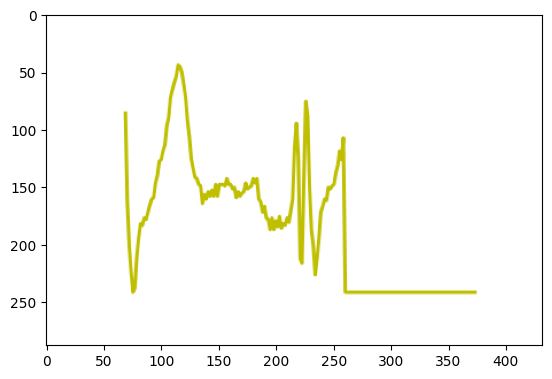

In [18]:
plt.imshow(loaded["images"][0])

In [ ]:
loaded

In [19]:
loaded["labels"][0]

np.int64(2)

In [ ]:
import cv2
from PIL import Image

In [ ]:
from pythonScript.modules.data_preprocessing import apply_canny, apply_morphology, black_and_white

In [ ]:
from torchvision import transforms

In [ ]:
from torch.utils.data import DataLoader, Dataset

class ArtifactDataset(Dataset):
    def __init__(self, artifact_uri: str, artifact_name: str, run, transform=None):
        self.artifact_uri = artifact_uri
        self.transform = transform

        # Download Artifact from Wandb
        artifact = run.use_artifact(artifact_uri, type="dataset")
        artifact_dir = artifact.download()
        artifact_data = np.load(os.path.join(artifact_dir, artifact_name))

        self.images = artifact_data["images"]
        self.labels = artifact_data["labels"]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image = cv2.resize(image, (224, 224))

        combined_image = Image.fromarray(np.uint8(image * 255))

        if self.transform:
            combined_image = self.transform(combined_image)

        return combined_image, self.labels[index]

In [ ]:
class VerkehrsschilderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label, subfolder in enumerate(["y", "n"]):
            folder_path = os.path.join(self.root_dir, subfolder)
            for image_name in os.listdir(folder_path):
                self.images.append(os.path.join(folder_path, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)

        canny_image = apply_canny(image, (224, 224))
        morphology_image = apply_morphology(image, (224, 224))
        bw_image = black_and_white(image, (224, 224))

        combined_image = np.concatenate(
            (canny_image, morphology_image, bw_image), axis=-1
        )
        combined_image = Image.fromarray(np.uint8(combined_image))
        if self.transform:
            combined_image = self.transform(combined_image)

        return combined_image, label

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomGrayscale(p=0.2),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
dataset = VerkehrsschilderDataset("data", transform)

In [ ]:
plt.imshow(dataset[0][0].permute(1,2,0))

In [ ]:
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
with wandb.init(project="VisionTransformer") as run:
    run.name = "deleteme"
    training_dataset = ArtifactDataset(
        "silvan-wiedmer-fhgr/VisionTransformer/swissimage-10cm-preprocessing:v1",
        "training-preprocessing.npy",
        run,
        transform,
    )

    training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)


    for images, labels in training_loader:
        plt.imshow(images[5].permute(1,2,0))
        break

In [ ]:
len(loaded["images"])

In [ ]:
loaded["images"].shape

In [ ]:
loaded["images"][0].shape

In [ ]:
cv2.resize(loaded["images"][0], (224, 224)).shape

In [ ]:
plt.imshow(cv2.resize(loaded["images"][0], IMAGE_SIZE))

In [ ]:
plt.imshow(loaded["images"][0])